# Areal Project

Project by Mykola Liashuha, Paavo Camps

<div>
<img src="logo.jpg" width=150 ALIGN="left" border="20">
<h1> Starting Kit for raw data (images)</h1>
<br>This code was tested with <br>
Python 3.6.7 <br>
Created by Areal Team <br><br>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div>
    <h2>Introduction </h2>
     <br>
Aerial imagery has been a primary source of geographic data for quite a long time. With technology progress, aerial imagery became really practical for remote sensing : the science of obtaining information about an object, area or phenomenon.
Nowadays, there are many uses of image recognition spanning from robotics/drone vision to autonomous driving vehicules or face detection.
<br>
In this challenge, we will use pre-processed data, coming from landscape images. The goal is to learn to differentiate common and uncommon landscapes such as a beach, a lake or a meadow.
    Data comes from part of the data set (NWPU-RESISC45) originally used in <a href="https://arxiv.org/pdf/1703.00121.pdf?fbclid=IwAR16qo-EX_Z05ZpxvWG8F-oBU0SlnY-3BPCWBVVOGPyJcVy7BBqCKjnsvJo">Remote Sensing Image Scene Classification</a>. This data set contains 45 categories while we only kept 13 out of them.

References and credits: 
Yuliya Tarabalka, Guillaume Charpiat, Nicolas Girard for the data sets presentation.<br>
Gong Cheng, Junwei Han, and Xiaoqiang Lu, for the original article on the chosen data set.
</div>

### Requirements 

The next cell will install all the required dependencies on your computer. You should consider replacing pip with pip3 if pip is related to python2.7 on your computer, or comment it if you already have the dependencies/are running in the docker of the challenge (runnable with the name areal/codalab:pytorch if you know how to run a docker).

In [2]:
#!pip install --user -r requirements.txt

In [3]:
import numpy as np
import random
import re

In [4]:
model_dir = "sample_code_submission"
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'

In [5]:
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir);

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

Go through the challenge website and watch the trailer video.

#### Question 1: Briefly explain the problem.

We are to classify images of certain landscapes to 13 different classes(beach,chaparral,cloud,desert,forest,island,lake,meadow,mountain,river,sea,snowberg,wetland).

#### Question 2: What is the scoring metric used to evaluate submissions?

The accuracy that is used to evaluate submission is the percentage of rightly identified(prediction==solution) classes.

aacuracy = (n_true_positive + n_true_negative) / (n_all_samples)


<div>
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
</div>

In [7]:
data_dir = 'sample_data'
#data_dir = '../public_data_tp5' # download "public_data" from the challenge website
data_name = 'Areal'

<h2 style="color:red " >Warning</h2>

<p style="font-style:italic"> In case you want to load the full data </p> 
Files being big, your computer needs to have enough space available in your RAM. It should take about 3-4GB while loading and 1.5GB in the end.

In [8]:
from ingestion_program.data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)

Reading sample_data/Areal_train from AutoML format
Number of examples = 65
Number of features = 49152
        Class
0       beach
1   chaparral
2       cloud
3      desert
4      forest
5      island
6        lake
7      meadow
8    mountain
9       river
10        sea
11   snowberg
12    wetland
Number of classes = 13


In [164]:
data.shape

(5200, 49153)

In [10]:
data.head()

,pixel_1_1_R,pixel_1_1_G,pixel_1_1_B,pixel_1_2_R,pixel_1_2_G,pixel_1_2_B,pixel_1_3_R,pixel_1_3_G,pixel_1_3_B,pixel_1_4_R,...,pixel_128_126_R,pixel_128_126_G,pixel_128_126_B,pixel_128_127_R,pixel_128_127_G,pixel_128_127_B,pixel_128_128_R,pixel_128_128_G,pixel_128_128_B,target
0,145,145,121,113,113,89,73,75,53,65,...,191,164,134,196,169,139,202,175,145,desert
1,193,168,138,191,166,136,201,176,146,194,...,196,171,140,197,172,141,201,176,145,desert
2,83,86,67,65,68,49,73,78,58,78,...,115,110,91,115,107,88,141,133,114,meadow
3,16,52,48,15,51,47,15,52,45,15,...,65,83,61,58,75,56,68,85,66,river
4,60,79,47,80,99,67,62,81,51,45,...,182,197,202,121,135,144,120,137,147,mountain


In [11]:
# data.describe()

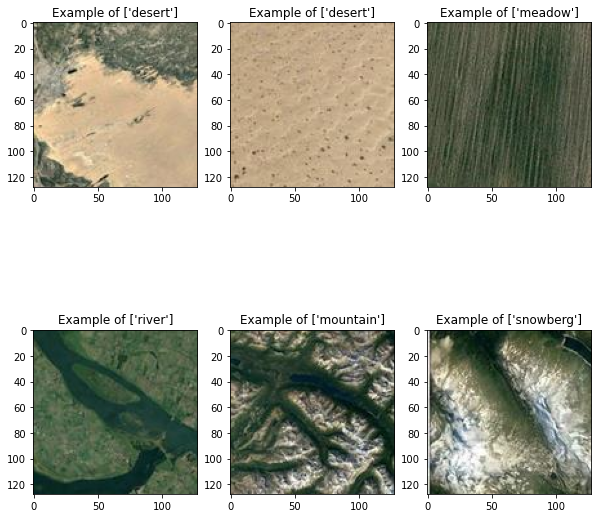

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

num_toshow = 6
fig, _axs = plt.subplots(nrows=2, ncols=3, figsize=(10,10))
fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()


for i in range(num_toshow):
    img = data.iloc[i].values[:-1].reshape(128,128,3)
    label = data.iloc[i].values[-1:]
    axs[i].set_title('Example of {}'.format(label))
    axs[i].imshow(img.astype(float) / 255)

plt.show()

We can use a library to extract features with different algorithms. Here we print the example pictures from before with the different extracted features on top of them. We can see that the algorithm espacially finds the edges of the pictures(dessert has no features on the bleak surfaces etc.)
To go through the pcitures use any key of the keyboard.

In [13]:
import cv2 as cv

for i in range(num_toshow):
    img = data.iloc[i].values[:-1].reshape(128,128,3)
    new_img = (img.astype(float) / 255)
    gray= cv.cvtColor(new_img.astype('float32'),cv.COLOR_BGR2GRAY)
    kaze = cv.KAZE_create()
    image8bit = cv.normalize(gray, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
    kp, des = kaze.detectAndCompute(image8bit,None)
    img=cv.drawKeypoints(image8bit,kp,new_img)
    cv.imshow('kaze_keypoints.jpg',img)
    cv.waitKey(0)

In [ ]:
data.head()

In [ ]:
#np.array(data)
#np.array(features)

In [ ]:
print(data.iloc[:, -1:])
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]

In [ ]:
np.unique(data["target"])#.shape

In [ ]:
data[data["target"]=="island"].shape

/home/mykola/anaconda3/envs/cuda9/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


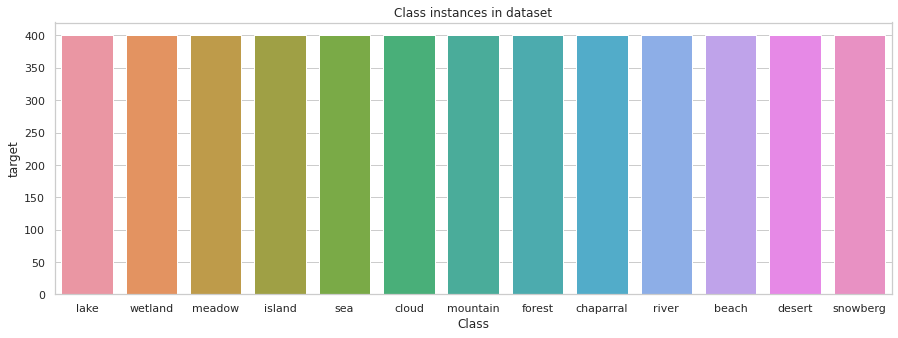

In [73]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,5))
plt.xlabel('Class')
plt.ylabel('Nnumber of samples')
plt.title("Class instances in dataset")
sns.barplot(data.iloc[:, -1:].target.value_counts().index, data.iloc[:, -1:].target.value_counts())
plt.show()

#### Code 1: compute statistics of the dataset.

* How many features?
* How many data points?
* How many classes?
* What is the most represented class?
* What is the least represented class?

In [ ]:
#Features: 128*128*3
#Data points: 5200
#Classes: 13
#They are equally represented: all by 400 samples

# Step 2 : Building a predictive model

<h2 style="color:red " >Warning</h2>

<p style="font-style:italic"> In case you want to load the full data </p> 
This time, also, still make sure that your RAM has at least 2-3GB available.

In [8]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=False, verbose=True)
print(D)

Info file found : /home/mykola/Projects/public_data_tp5/Areal_public.info
========= Reading ../public_data_tp5/Areal_feat.type
[+] Success in  0.00 sec
========= Reading ../public_data_tp5/Areal_train.data
[+] Success in 80.39 sec
========= Reading ../public_data_tp5/Areal_train.solution
[+] Success in  0.02 sec
========= Reading ../public_data_tp5/Areal_valid.data
[+] Success in 31.76 sec
========= Reading ../public_data_tp5/Areal_valid.solution
[+] Success in  0.00 sec
========= Reading ../public_data_tp5/Areal_test.data
[+] Success in 31.18 sec
========= Reading ../public_data_tp5/Areal_test.solution
[+] Success in  0.00 sec
DataManager : Areal
info:
	usage = Sample dataset Areal data
	name = areal
	task = multiclass.classification
	target_type = Categorical
	feat_type = Numerical
	metric = accuracy
	time_budget = 12000
	feat_num = 49152
	target_num = 13
	label_num = 13
	train_num = 5200
	valid_num = 1950
	test_num = 1950
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format 

In [12]:
X_train = D.data['X_train']
Y_train = D.data['Y_train']

### Processing

Basically, there are two approaches:

* Use raw data as input. This may be the good way to go with, for instance, deep learning models.
* Do feature engineering: process the data to create features. You can then use this features as the input of your classifier (Random forest, SVM, etc.). An example of feature is the number of blue pixel in the image. Feature extraction can also be done by a CNN.

We noticed that there is the possiblity of overfitting because our training feature has so many variables and applied a PCA to account for that. Interestingly the PCA with a 1000 components still hurt the model quite a bit, the accuracy dropping down to 0.5967 for our validation set. Therefore we left the PCA out.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


X_train, X_validation, y_train, y_validation = train_test_split(D.data['X_train'], D.data['Y_train'], test_size=1500, random_state=42)
X_train = create_features(X_train)
X_validation = create_features(X_validation)

pca = PCA(n_components=1000)
X_train = pca.fit_transform(X_train)
X_validation = pca.transform(X_validation)

print()

rfc = RandomForestClassifier(class_weight="balanced")
rfc.fit(X_train, y_train)
Y_hat_train = rfc.predict(X_train)
Y_hat_valid = rfc.predict(X_validation)

scoring_function(y_train, Y_hat_valid)
scoring_function(y_validation, Y_hat_valid)

Here we are using pre created methods of libraries that extract features from image data. Some of these functions are taken from the blogpost or the opencv tutorials.
<br>
kaze: is an algorithm that detects edges in the image. Mountains might have different kind of edges in the image than beaches and the detected edges might be a useful feature.
<br>
hu moments: there are 7 hu moments in images that can be calculated to be unfased translation, scale, rotation and reflection and are therefore a useful feature
<br>
haralick: Haralick creates a representation of the texture of the image by calculating the distribution of gray levels of a pixel compared to its neighboring pixels.
<br>
fd histogram: the histogram creates a representation of the stregnth of the used colors of the image. A picture of a beach might have a lot of strong blue colors whereas a swamp might have a lot of green pixels in the overall image.

In [18]:
import cv2 as cv
def extract_features(image, vector_size=32):
    try:
        #alg = cv.KAZE_create()
        #image = (image.astype(float) / 255)
        image = image.reshape(128,128,3)
        image= cv.cvtColor(image.astype('float32'),cv.COLOR_BGR2GRAY)
        #alg = cv.SIFT_create()
        alg = cv.KAZE_create()
        kps = alg.detect(image)
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv.error as e:
        print('Error: ', e)
        return None
    return dsc

In [39]:
import mahotas

def fd_hu_moments(image):
    image = cv.cvtColor(image.reshape(128,128,3), cv.COLOR_BGR2GRAY)
    feature = cv.HuMoments(cv.moments(image)).flatten()
    return feature

def fd_haralick(image):    # convert the image to grayscale
    #image = (image.astype(float) / 255)
    gray = cv.cvtColor(image.reshape(128,128,3), cv.COLOR_BGR2GRAY)
    #print(gray)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick
 
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv.cvtColor(image.reshape(128,128,3), cv.COLOR_BGR2HSV)
    # compute the color histogram
    bins = 8
    hist  = cv.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv.normalize(hist, hist)
    return hist.flatten()

In [57]:
def create_features(images):
    kaze_features = np.array([extract_features(X) for X in images])
    hu_features = np.array([fd_hu_moments(X) for X in images])
    haralick_features = np.array([fd_haralick(X) for X in images])
    hist_features = np.array([fd_histogram(X) for X in images])
    return np.hstack((hu_features,haralick_features, hist_features))

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(D.data['X_train'], D.data['Y_train'], test_size=1500, random_state=42)


In [52]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)

Using scoring metric: accuracy


In [58]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight="balanced")
scaler = sklearn.preprocessing.MinMaxScaler()
data_train = scaler.fit_transform(create_features(X_train))
clf.fit(data_train, y_train)
Y_hat_train = clf.predict(scaler.transform(create_features(X_train)))
Y_hat_valid = clf.predict(scaler.transform(create_features(X_validation)))

In [59]:
scoring_function(y_validation, Y_hat_valid)

0.848

In [61]:
cl = RandomForestClassifier(class_weight="balanced")
scaler = sklearn.preprocessing.MinMaxScaler()
data_train = scaler.fit_transform(create_features(D.data['X_train']))
cl.fit(data_train, D.data['Y_train'])
Y_hat_train = cl.predict(data_train)
Y_hat_valid = cl.predict(scaler.transform(create_features(D.data['X_valid'])))
Y_hat_test = cl.predict(scaler.transform(create_features(D.data['X_test'])))

/home/mykola/anaconda3/envs/cuda9/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [63]:
scoring_function(D.data['Y_train'], Y_hat_train)

1.0

In [40]:
from sklearn.svm import SVC
scv = SVC()
scv.fit(create_features(D.data['X_train']), D.data['Y_train'])
Y_hat_train = scv.predict(create_features(D.data['X_train']))
Y_hat_valid = scv.predict(create_features(D.data['X_valid']))
Y_hat_test = scv.predict(create_features(D.data['X_test']))

/home/paavo/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [41]:
scoring_function(D.data['Y_train'], Y_hat_train)

0.3486538461538462

In [64]:
#cl.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

sample_result_submission/Areal_test.predict
sample_result_submission/Areal_train.predict
sample_result_submission/Areal_valid.predict


In [10]:
X_train = D.data['X_train']
Y_train = D.data['Y_train']
X_train.shape, Y_train.shape

((5200, 49152), (5200, 1))

### Processing

Basically, there are two approaches:

* Use raw data as input. This may be the good way to go with, for instance, deep learning models.
* Do feature engineering: process the data to create features. You can then use this features as the input of your classifier (Random forest, SVM, etc.). An example of feature is the number of blue pixel in the image. Feature extraction can also be done by a CNN.

In [ ]:
D.data['Y_valid'].shape

### Use of the baseline model

Using our BasicCNN model needs PyTorch libraries installed.

In case you have them but still encounter errors related to them, you should probably do an upgrade : 

    pip install -U torch

In [87]:
import sklearn
# scaler = sklearn.preprocessing.MinMaxScaler()
# X_train = scaler.fit_transform(D.data['X_train'])
# X_valid = scaler.transform(D.data['X_valid'])
# X_test = scaler.transform(D.data['X_test'])


X_train = D.data['X_train']
X_valid = D.data['X_valid']
X_test = D.data['X_test']


In [88]:
from sklearn.model_selection import train_test_split
Xx_train, Xx_test, yy_train, yy_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
Xx_train.shape, Xx_test.shape, yy_train.shape, yy_test.shape

((4160, 49152), (1040, 49152), (4160, 1), (1040, 1))

In basic CNN class there were used such models as:

- SimpleConvModel: 1 Convolutional Layer with 2 Fully Connected Layers. This simple model gave accuracy of 0.65 during submission
- ResNet: in order to try more deep CNN we used this model. It achieved 0.75 accuracy during submission. Such model drastically overperformed simple convolutional model due to its depth

As well as, there were also applied L2 regularizaition, DropOut and weight decay in order to revent overfitting. Also there was an attempt to use augmentation of dataset, though it was computationally not very easy due to high deamnd of RAM (imgaug and torchvision.transofrmers). That's why only small portions of dataset were put through augmentation, but it increased generalization on test set only by few percent.

The highest accuracy rates were received using MinMaxScaler usually +5 percent increase comparing to Standardization method provided initially in the code.

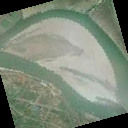

In [89]:
import torchvision
transforms_pytorch = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(50),
    torchvision.transforms.RandomRotation(50),
#     torchvision.transforms.ToTensor()
])

transforms_pytorch(D.data['X_train'][0].reshape(128,128,3))

In [159]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
from torchvision import transforms
from sklearn.base import BaseEstimator
from sklearn.preprocessing import normalize
from PIL import Image
from os.path import isfile
import torchvision
import PIL
import imgaug.augmenters as iaa

from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)


seq = iaa.Sequential([
#     iaa.Crop(percent=(0, 0.1)),
#     iaa.Fliplr(0.5),
#     iaa.Flipud(0.5),
    iaa.GaussianBlur(sigma=(0, 3.0)),
#     iaa.Affine(
#         scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
#         translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
#         rotate=(-25, 25),
#         shear=(-8, 8)
#     ),
    iaa.LinearContrast((0.75, 1.5)),
])

transforms_pytorch = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(10),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor()
])

def requires_grad(p):
    return p.requires_grad


class SimpleConvModel(nn.Module):
    def __init__(self, out_channel_conv=16, linear_hidden_size=128, out_class=13):
        super(SimpleConvModel, self).__init__()

        self.out_channel_conv = out_channel_conv
        self.linear_hidden_size = linear_hidden_size
        self.out_class = out_class

        self.seq1 = nn.Sequential(
                                  nn.Conv2d(3, self.out_channel_conv, (3,3), stride=3),
                                  nn.MaxPool2d(5),
                                  nn.ReLU(),
#                                   nn.Conv2d(self.out_channel_conv, self.out_channel_conv, (3,3), stride=1),
#                                   nn.MaxPool2d(2),
#                                   nn.ReLU()
                                 )

        self.seq2 = nn.Sequential(nn.Linear(self.out_channel_conv * 8 * 8, self.linear_hidden_size),#self.linear_hidden_size),
                                  nn.Dropout(0.25),
                                  nn.ReLU(),
                                  nn.Linear(self.linear_hidden_size, self.out_class),
                                  nn.Softmax(dim = 1))

    def forward(self, x):
        out1 = self.seq1(x)
#         print(out1.shape)
        out2 = out1.view(-1, self.out_channel_conv*8*8)
        out3 = self.seq2(out2)

        return out3

class BasicCNN(BaseEstimator):
    def __init__(self, learning_rate=1e-3, nb_epoch = 10, batch_size = 32, verbose=False, use_cuda=False,
                out_channel_conv=32, linear_hidden_size=128, estim_test_score = False):
        super(BasicCNN, self).__init__()
        if learning_rate is None:
            learning_rate = 1e-4
        if nb_epoch is None:
            nb_epoch = 40
        if batch_size is None:
            batch_size = 32
        if verbose is None:
            verbose = False
        if use_cuda is None:
            use_cuda = False
        if out_channel_conv is None:
            out_channel_conv = 32
        if linear_hidden_size is None:
            linear_hidden_size = 128
        self.learning_rate = learning_rate
        self.nb_epoch = nb_epoch
        self.batch_size = batch_size
        self.verbose = verbose
        self.use_cuda = use_cuda
        self.out_channel_conv = out_channel_conv
        self.linear_hidden_size = linear_hidden_size
        self.model_conv = SimpleConvModel(self.out_channel_conv, self.linear_hidden_size)
#         self.model_conv = torchvision.models.resnet.resnet34(num_classes=13)
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        if self.use_cuda:
            self.model_conv.cuda()
            self.criterion.cuda()
        # Optimizer
        self.estim_test_score = estim_test_score
        print(out_channel_conv, linear_hidden_size)
        self.optim = optim.Adam(self.model_conv.parameters(), lr=self.learning_rate, weight_decay=0.00005)

    def fit(self, X, Y):
        '''
            param X: numpy.ndarray
                shape = (num_sample, C * W * H)
                with C = 3, W = H = 128
            param Y: numpy.ndarray
                shape = (num_sample, 1)
        '''
        y_train_est = Y.copy()
        x_test = self.process_data(Xx_test, augment=False)
        y_test = self.process_label(yy_test)
        X = self.process_data(X)
        Y = self.process_label(Y)
        self.model_conv.train()
        nb_batch = int(X.shape[0] / self.batch_size)
        for e in range(self.nb_epoch):
            sum_loss = 0
            for i in range(nb_batch):
                self.optim.zero_grad()
                beg = i * self.batch_size
                end = min(X.shape[0], (i + 1) * self.batch_size)
                x = X[beg:end]
                y = Y[beg:end]
                if self.use_cuda:
                    x, y = x.cuda(), y.cuda()
                out = self.model_conv(x)
                loss = self.criterion(out, y)
                loss.backward()
                self.optim.step()
                sum_loss += loss.item()
#                 print(loss.item())
            sum_loss /= nb_batch
            if self.verbose:
                print("Epoch %d : loss = %f" % (e, sum_loss))
                pred_score = scoring_function(y_train_est, self.predict(X, preproc=False))
                print('Training score for the', metric_name, 'metric = %5.4f' % pred_score)
                if self.estim_test_score:
                    print('Test score for the', metric_name, 'metric = %5.4f' % scoring_function(yy_test, self.predict(x_test, preproc=False)))
                
        print(pred_score)
        return pred_score

    def process_data(self, X, augment=True):
        print('fst sample', X[0][0])
        n_sample = X.shape[0]
        X = X.reshape(n_sample, 3, 128, 128)
        mean = np.mean(X, axis=1)[:, np.newaxis]
        std = np.std(X, axis=1)[:, np.newaxis]


#         if augment or True:
#             ls = []
#             for sample in X:
#                 ls.append(transforms_pytorch(sample.reshape(128,128,3)))
#             X = torch.stack(ls)
# # #             X = X + 0.1*np.random.uniform(size=X.shape)
# # #             X = seq(images=X)

# #         X = (X - 127.5) / 127.5
#             X = X.cpu().numpy()


        
        
        X = (X - mean) / (std + 1e-8)

        X = X.astype(np.float)

        print(X.max(), X.min())
        return torch.Tensor(X)

    def process_label(self, y):
        res = torch.zeros(1)
        for i in range(y.shape[0]):
            l = torch.Tensor([y[i,0]])
            res = torch.cat((res, l))
        return res[1:].type(torch.long)

    def predict_all(self, X):
        self.model_conv.eval()
        X = self.process_data(X)
        if self.use_cuda:
            X = X.cuda()
        pred = self.model_conv(X).argmax(dim=1).cpu().numpy()
        return pred
    
    def predict(self, X, preproc=True):
        '''
            param X: numpy.ndarray
                shape = (num_sample, C * W * H)
                with C = 3, W = H = 128
            return: numpy.ndarray
                of int with shape (num_sample) ?
                of float with shape (num_sample, num_class) ?
                of string with shape (num_sample) ?
        '''
        # inverted_dico = {v:k for k,v in self.label_dico.items()}
        self.model_conv.eval()
        
        if preproc:
            X = self.process_data(X, augment=False)

        nb_batch = int(X.shape[0] / self.batch_size)
        pred = []
        for i in range(nb_batch):
            beg = i * self.batch_size
            end = min(X.shape[0], (i + 1) * self.batch_size)
            x = X[beg:end]
            
            if self.use_cuda:
                x = x.cuda()
            preds = self.model_conv(x).argmax(dim=1).cpu().numpy()
            pred.append(preds)
        
        if end !=X.shape[0]:
            x = X[end:]

            if self.use_cuda:
                x = x.cuda()
            preds = self.model_conv(x).argmax(dim=1).cpu().numpy()
            pred.append(preds)
        pred = np.array([[item] for sublist in pred for item in sublist])

        return pred

    def save(self, path="./"):
        pickle.dump(self, open(path + '_model.pickle', "wb"))

    def load(self, path="./"):
        modelfile = path + '_model.pickle'
        if isfile(modelfile):
            with open(modelfile, 'rb') as f:
                self = pickle.load(f)
            print("Model reloaded from: " + modelfile)
        return self

Using scoring metric: accuracy


Before creating a model we should fistly clear the cache since they may overflow the RAM.

In [160]:
import gc

del m
gc.collect()

import torch
torch.cuda.empty_cache()

In [161]:
m = BasicCNN(verbose=True, use_cuda=True, nb_epoch=20, batch_size=16, learning_rate=0.0001,
            out_channel_conv=64, linear_hidden_size=64)
# print(m.model_conv)
trained_model_name = model_dir + '/' + data_name

64 64


Below is a code for trainig the model on train and test set compile from original X_train and Y_train.

In [148]:
#Train on train set data
m.nb_epoch = 40
res = m.fit(Xx_train, yy_train)


fst sample 110
1.414213562255448 -1.414213562255448
fst sample 69
1.414213562255448 -1.414213562255448
Epoch 0 : loss = 2.270555
Training score for the accuracy metric = 0.4594
Epoch 1 : loss = 2.219853
Training score for the accuracy metric = 0.5014
Epoch 2 : loss = 2.207405
Training score for the accuracy metric = 0.5132
Epoch 3 : loss = 2.197648
Training score for the accuracy metric = 0.5236
Epoch 4 : loss = 2.188721
Training score for the accuracy metric = 0.5327
Epoch 5 : loss = 2.180508
Training score for the accuracy metric = 0.5375
Epoch 6 : loss = 2.172893
Training score for the accuracy metric = 0.5433
Epoch 7 : loss = 2.165854
Training score for the accuracy metric = 0.5478
Epoch 8 : loss = 2.159283
Training score for the accuracy metric = 0.5526
Epoch 9 : loss = 2.153263
Training score for the accuracy metric = 0.5560
Epoch 10 : loss = 2.147722
Training score for the accuracy metric = 0.5579
Epoch 11 : loss = 2.142535
Training score for the accuracy metric = 0.5606
Epoch 1

In [ ]:
#Train on full data
m.nb_epoch = 250
res = m.fit(X_train, Y_train)

Below is the code for running grid search of parameters for simple_convolutinal model

In [67]:
# torch.autograd.set_detect_anomaly(True)
out_channel_convs = [32,64,256,512]
linear_hidden_size = [32, 64,256,512]
lrs = [0.001, 0.0001]
ress = {}
for chn in out_channel_convs:
    for hidden in linear_hidden_size:
        for lr in lrs:

            gc.collect()
            torch.cuda.empty_cache()

            m = BasicCNN(verbose=True, use_cuda=True, nb_epoch=10, batch_size=8, learning_rate=lr,
                    out_channel_conv=chn, linear_hidden_size=hidden)
            trained_model_name = model_dir + '/' + data_name
            res = m.fit(X_train.reshape((-1,128,128,3)), Y_train)
            ress[(chn, hidden, lr)] = res
            del m
            
ress

In [24]:
import gc

gc.collect()

import torch
torch.cuda.empty_cache()

In [162]:
m.save(trained_model_name)  
m.batch_size = 4
Y_hat_train = m.predict(X_train)
Y_hat_valid = m.predict(X_valid)
Y_hat_test = m.predict(X_test)
m.batch_size = 8

fst sample 109
1.414213562255448 -1.414213562255448
fst sample 14
1.414213562255448 -1.414213562255448
fst sample 60
1.414213562255448 -1.414213562255448


In [163]:
m.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

sample_result_submission/Areal_test.predict
sample_result_submission/Areal_train.predict
sample_result_submission/Areal_valid.predict


#### Question 3: What are the hyperparameters of a CNN?

Apart from learning parameters such as number of layers similar to a normal neural net the CNN specifically has the size of the kernels that are used to detect features, the step size with which the kernel is applied as well as padding of the sides of the image.

# Scoring the result

Obviously, since it is made with sample_data, which has too few samples, results won't be really good

In [19]:
from libscores import get_metric
import libscores
type(libscores)

module

In [20]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)

Using scoring metric: accuracy


In [21]:
len(D.data['Y_valid']), len(D.data['Y_test'])

(0, 0)

In [22]:
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
if len(D.data['Y_valid']) > 0 and len(D.data['Y_test']) > 0:
    print('Valid score for the', metric_name, 'metric = %5.4f' % scoring_function(D.data['Y_valid'], Y_hat_valid))
    print('Test score for the', metric_name, 'metric = %5.4f' % scoring_function(D.data['Y_test'], Y_hat_test))

Ideal score for the accuracy metric = 1.0000
Training score for the accuracy metric = 0.6687


## Confusion matrix

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
conf_matr = confusion_matrix(Y_train[:Y_hat_train.shape[0]], Y_hat_train)
conf_matr

array([[  0,  16,  54,  22,   0,  65,   2,   0,  50,  78,  44,  65,   4],
       [  0, 274,   1,  11,  62,   0,   0,   0,  24,   6,   0,   1,  21],
       [  0,   2, 229,   6,   3,  28,   5,   0,  12,  46,  35,  18,  16],
       [  0,  10,   1, 352,   0,   0,   0,   0,  25,   3,   0,   8,   1],
       [  0,   0,   0,   0, 360,   0,   0,   4,   0,   9,   0,   0,  27],
       [  0,   0,  14,   3,   4, 322,   5,   0,   6,  35,   9,   0,   2],
       [  0,  38,   6,   1,  18,  10, 193,   9,  24,  68,   3,   7,  23],
       [  0,   0,   0,   1,  12,   0,   2, 362,   5,   5,   0,   0,  13],
       [  0,  31,   3,  19,  39,   2,   8,  20, 176,  63,   2,   8,  29],
       [  0,  18,   8,   3,  21,   1,  18,  14,  19, 267,   8,   4,  19],
       [  0,   0,  15,   0,   1,  16,   1,   0,   0,  20, 342,   5,   0],
       [  0,   7,   5,   0,   1,   0,   0,   0,   4,   4,   0, 379,   0],
       [  0,   0,   1,   0,  70,   3,  17,  30,  26,  27,   4,   1, 221]])

#### Code 4: display the confusion matrix with a colored heatmap

<AxesSubplot:>

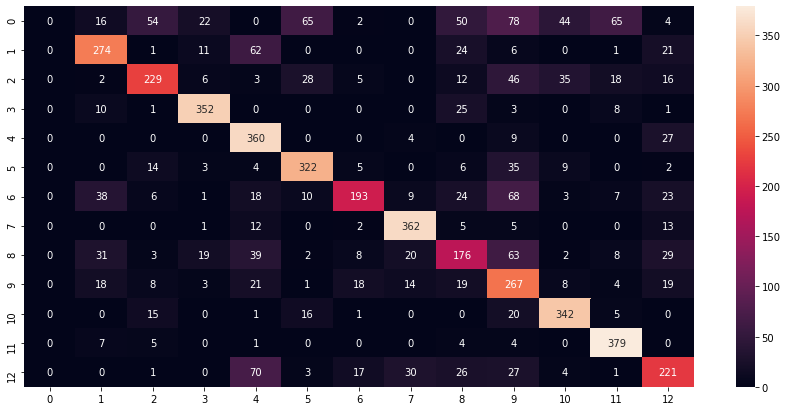

In [31]:
plt.figure(figsize = (15,7))
sn.heatmap(conf_matr, annot=True,  fmt='g')

#### Question 4: what does the confusion matrix represent?

On one axis the confusion matrix shows the predictions and on one side the solutions. The middle diagonal shows where both are the same. To the side there are cases where may a beach is classified as mountains. If there is a large number of missclassification between two classes that means that the model has difficulties distinguishing the two(so one could create features to differentiate the two, or change the model architecture)

## Cross validation

CV scores on sample_data doesn't have enough data, and so isn't meaningful.
Run it with the full data to see meaningful values.

In [113]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [157]:
cnn = BasicCNN(verbose=True, use_cuda=True, nb_epoch=40, batch_size=16, learning_rate=0.0001,
            out_channel_conv=64, linear_hidden_size=64, estim_test_score=False)
fit_params = {
    'verbose':True, 
    'use_cuda':True, 
    'nb_epoch':40, 
    'batch_size':16, 
    'learning_rate':0.0001,
    'out_channel_conv':32, 
    'linear_hidden_size':128,
    'estim_test_score':False
}
scores = cross_val_score(cnn, X_train, Y_train, cv=3, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

64 64
64 64
fst sample 110
1.414213562255448 -1.414213562255448
fst sample 195
1.414213562255448 -1.414213562255448
Epoch 0 : loss = 2.472065
Training score for the accuracy metric = 0.3644
Epoch 1 : loss = 2.314947
Training score for the accuracy metric = 0.4547
Epoch 2 : loss = 2.256879
Training score for the accuracy metric = 0.4801
Epoch 3 : loss = 2.233681
Training score for the accuracy metric = 0.4934
Epoch 4 : loss = 2.217991
Training score for the accuracy metric = 0.5046
Epoch 5 : loss = 2.205000
Training score for the accuracy metric = 0.5159
Epoch 6 : loss = 2.193426
Training score for the accuracy metric = 0.5254
Epoch 7 : loss = 2.182131
Training score for the accuracy metric = 0.5413
Epoch 8 : loss = 2.170751
Training score for the accuracy metric = 0.5540
Epoch 9 : loss = 2.160544
Training score for the accuracy metric = 0.5635
Epoch 10 : loss = 2.151407
Training score for the accuracy metric = 0.5716
Epoch 11 : loss = 2.143096
Training score for the accuracy metric = 0

Training score for the accuracy metric = 0.6184
Epoch 24 : loss = 2.078316
Training score for the accuracy metric = 0.6222
Epoch 25 : loss = 2.073661
Training score for the accuracy metric = 0.6259
Epoch 26 : loss = 2.069264
Training score for the accuracy metric = 0.6305
Epoch 27 : loss = 2.064877
Training score for the accuracy metric = 0.6334
Epoch 28 : loss = 2.060651
Training score for the accuracy metric = 0.6380
Epoch 29 : loss = 2.056636
Training score for the accuracy metric = 0.6412
Epoch 30 : loss = 2.052781
Training score for the accuracy metric = 0.6452
Epoch 31 : loss = 2.049043
Training score for the accuracy metric = 0.6478
Epoch 32 : loss = 2.045344
Training score for the accuracy metric = 0.6513
Epoch 33 : loss = 2.041807
Training score for the accuracy metric = 0.6530
Epoch 34 : loss = 2.038493
Training score for the accuracy metric = 0.6550
Epoch 35 : loss = 2.035251
Training score for the accuracy metric = 0.6559
Epoch 36 : loss = 2.031984
Training score for the ac

#### Question 5: Why is there a standard deviation associated with the cross-validation score?

The cross validation uses several folds(or particitions) of the data. Each of these folds hasits accuracy score, in the end the scores of all folds are added. The variations thus shows the variation of the scores. A low variation shows that the model did similarily well on all folds it is therefore more consistent and might be preferable to a different model with similar score and higher variability because it is more consistent.

/home/mykola/anaconda3/envs/cuda9/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


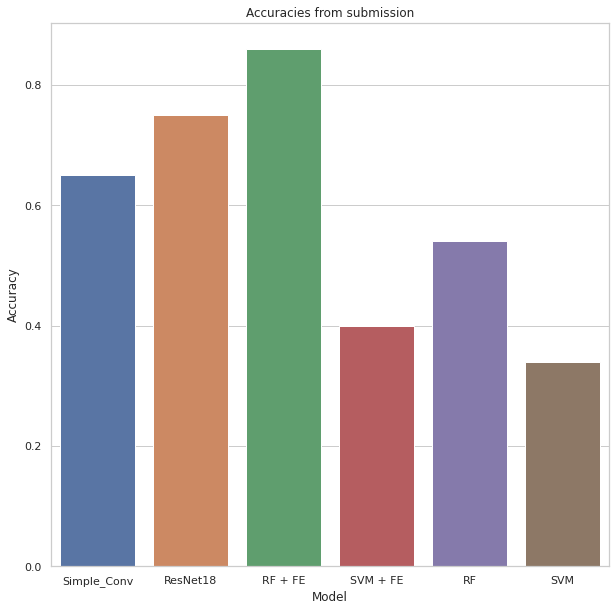

In [156]:
sns.set_theme(style="whitegrid")
models =     ['Simple_Conv', 'ResNet18', 'RF + FE', 'SVM + FE', 'RF', 'SVM']
accuracies = [0.65, 0.75, 0.86, 0.4, 0.54, 0.34]
# FE = Feature Extraction
plt.figure(figsize=(10,10))
ax = sns.barplot(models, accuracies)
ax.set(xlabel='Model', ylabel='Accuracy')
plt.title("Accuracies from submission")
plt.show()

# Submission

## Example

Example needs to have python3 installed

Test to see whether submission with ingestion program is working

In [33]:
!python3 $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

Using input_dir: /home/paavo/Saclay/OPT9/public_data_tp5
Using output_dir: /home/paavo/Saclay/OPT9/TP5/sample_result_submission
Using program_dir: /home/paavo/Saclay/OPT9/TP5/ingestion_program
Using submission_dir: /home/paavo/Saclay/OPT9/TP5/sample_code_submission

========== Ingestion program version 6 ==========

************************************************
******** Processing dataset Areal ********
************************************************
========= Reading and converting data ==========
Info file found : /home/paavo/Saclay/OPT9/public_data_tp5/Areal_public.info
========= Reading /home/paavo/Saclay/OPT9/public_data_tp5/Areal_feat.type
[+] Success in  0.00 sec
========= Reading /home/paavo/Saclay/OPT9/public_data_tp5/Areal_train.data
[+] Success in 60.49 sec
========= Reading /home/paavo/Saclay/OPT9/public_data_tp5/Areal_train.solution
[+] Success in  0.01 sec
========= Reading /home/paavo/Saclay/OPT9/public_data_tp5/Areal_valid.data
[+] Success in 22.36 sec
========= Rea

### Test scoring program

In [65]:
scoring_output_dir = 'scoring_output'
!python3 $score_dir/score.py $data_dir $result_dir $scoring_output_dir

======= Set 1 (Areal_train): accuracy(set1_score)=1.000000000000 =======


# Prepare the submission

In [66]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = './sample_code_submission_' + the_date + '.zip'
sample_result_submission = './sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

Submit one of these files:
./sample_code_submission_20-12-30-20-49.zip
./sample_result_submission_20-12-30-20-49.zip


# Try to submit your submissions on Codalab!